In [158]:
import pandas as pd
import ppscore as pps
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [159]:
depression_df = pd.read_csv("data.tsv", sep="\t", header=0)

### Add Somatic Depression Column

In [160]:
somatic_dep_cols = [
    "AD_MDEA3",  # apetite
    "AD_MDEA4",  # sleep
    "AD_MDEA6",  # fatigue
]
depression_df["SOMATICDEP"] = -9
any_2 = depression_df[somatic_dep_cols].eq(2).any(axis=1)
all_1 = depression_df[somatic_dep_cols].eq(1).all(axis=1)
depression_df.loc[any_2, "SOMATICDEP"] = 0
depression_df.loc[all_1, "SOMATICDEP"] = 1

### Choose Relevant Columns

In [161]:
indicator_col = "DEPRESSIONINDEX"
age_col = ["CATAG2", "CATAG3", "CATAG7"][0]

cols_dict = {
    "cat_bin": [
        "AD_MDEA3",
        "AD_MDEA4",
        "AD_MDEA6",
        "MJANDCOKE",
        "ILLICITDRUGUSE",
        "LSYRILLICIT",
        "COKECRACK",
        "OTHERILLICIT",
        "MJCOKELY",
        "COCCRKLY",
        "MJGT12MO",
        "COCGT12MO",
        "ANYGT12MO",
        "IRPRVHLT",
        "WORKFORCE",
        "CRIMEHIST",
        "ANYSDRUG",
        "ANYATTACK",
        "ANYTHEFT",
        "TXLCAD",
        "YOWRSATP",
        "YOWRSPLN",
        "ADWRDLOT",
        "ADWRSTHK",
        "YO_MDEA4",
        "ADWRSLEP",
        "YO_MDEA3",
        "ADWRELES",
        "RKIDSHH",
        "MARRIED",
        "CHILDRENINHOME",
        "SOMATICDEP",
        "IRSEX",
    ],
    "cat_nom": ["NEWRACE2", "ALCFMFPB", "EMPSTAT4", "CACHAR", "CATYPE", "IRMARIT"],
    "cat_ord": [
        "ANYINDEX",
        "IREDUC2",
        "INCOME",
        "INCOME_R",
        "POVERTY",
        "REVERSEPOP",
        "MOVESPY2",
        "NUMARREST",
        "HEALTH2",
        "DSTNCALM",
        "DSTTIRE",
        "DSTSITST",
        "DSTDEPRS",
        "DSTCHEER",
        "DSTNRVOS",
        "NOMARR2",
        age_col,
        indicator_col,
    ],
    "num_dis": ["SCHDSICK"],
    "num_con": [],
}

depression_df = depression_df[[col for cols in cols_dict.values() for col in cols]]

### Swap Non-Available Custom Values to nan

In [162]:
def swap_to_nan(df, cols, range):
    df = df.copy()
    lr, ur = range
    df[cols] = df[cols].where((df[cols] >= lr) & (df[cols] <= ur), np.nan)
    return df


depression_df = depression_df[depression_df["DEPRESSIONINDEX"] != -9]
depression_df.reset_index(drop=True, inplace=True)

range_dict = {
    "cat_bin": (0, 2),
    "cat_ord": (0, 20),
    "cat_nom": (0, 93),
    "num_dis": (0, 30),
    "num_con": (0, 0),
}

for col_type, cols in cols_dict.items():
    depression_df = swap_to_nan(depression_df, cols, range_dict[col_type])

### Drop columns that are all nan and filter out these names from the column lists

In [163]:
original_cols = depression_df.columns.tolist()
depression_df.dropna(axis=1, how="all", inplace=True)
remaining_cols = depression_df.columns.tolist()
dropped_cols = list(set(original_cols) - set(remaining_cols))

for key, value in cols_dict.items():
    cols_dict[key] = list(set(value) & set(remaining_cols))
    
print(f"Dropped empty columns: {dropped_cols}")

Dropped empty columns: ['DSTSITST', 'DSTDEPRS', 'DSTNCALM', 'DSTTIRE']


### Preliminary Analysis
Find N significantly different factors influencing the depression level.

DEPRESSIONINDEX - categorical ordinal variable 

In [164]:
def get_pearson(df):
    return df.corr("pearson")


def get_spearman(df):
    return df.corr("spearman")


def get_pps(df, indicator_col):
    return pps.predictors(df, indicator_col)[["x", "ppscore"]]


def analyse(
    df,
    cols_dict,
    indicator_col,
):
    pearson_df = get_pearson(
        df[cols_dict["cat_ord"] + cols_dict["num_dis"] + cols_dict["num_con"]]
    )
    spearman_df = get_spearman(
        df[cols_dict["cat_ord"] + cols_dict["num_dis"] + cols_dict["num_con"]]
    )
    pps_num_df = get_pps(
        df[cols_dict["num_dis"] + cols_dict["num_con"] + [indicator_col]], indicator_col
    )

    pps_cat_df = get_pps(
        df[cols_dict["cat_bin"] + cols_dict["cat_nom"] + cols_dict["cat_ord"]].astype(
            str
        ),
        indicator_col,
    )

    return pearson_df, spearman_df, pps_num_df, pps_cat_df


pearson_df, spearman_df, pps_num_df, pps_cat_df = analyse(
    df=depression_df,
    cols_dict=cols_dict,
    indicator_col=indicator_col,
)

<Axes: >

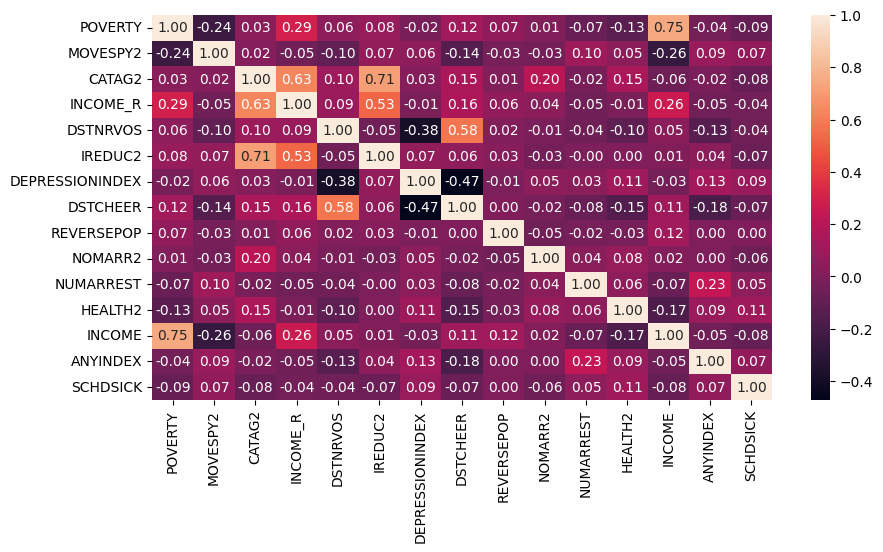

In [165]:
plt.figure(figsize=(10, 5))
sns.heatmap(pearson_df, annot=True, fmt=".2f")

<Axes: >

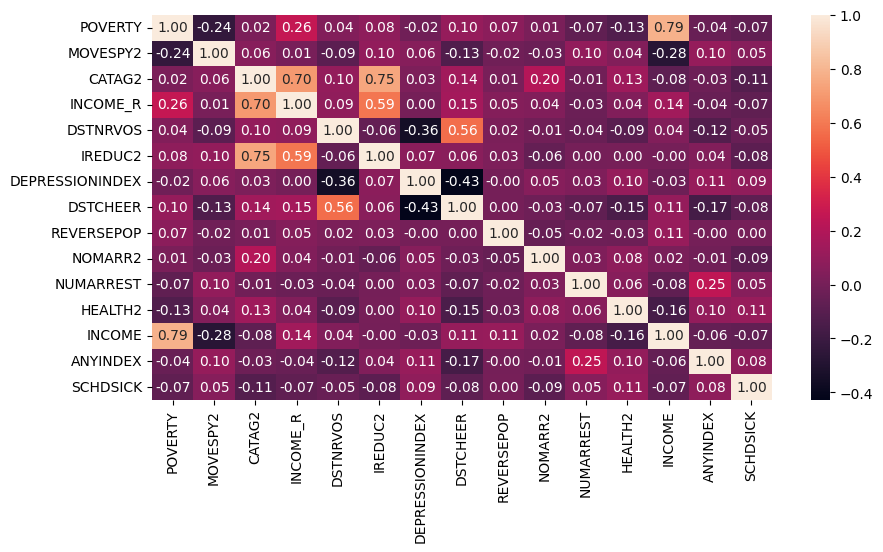

In [166]:
plt.figure(figsize=(10, 5))
sns.heatmap(spearman_df, annot=True, fmt=".2f")

<Axes: xlabel='ppscore', ylabel='x'>

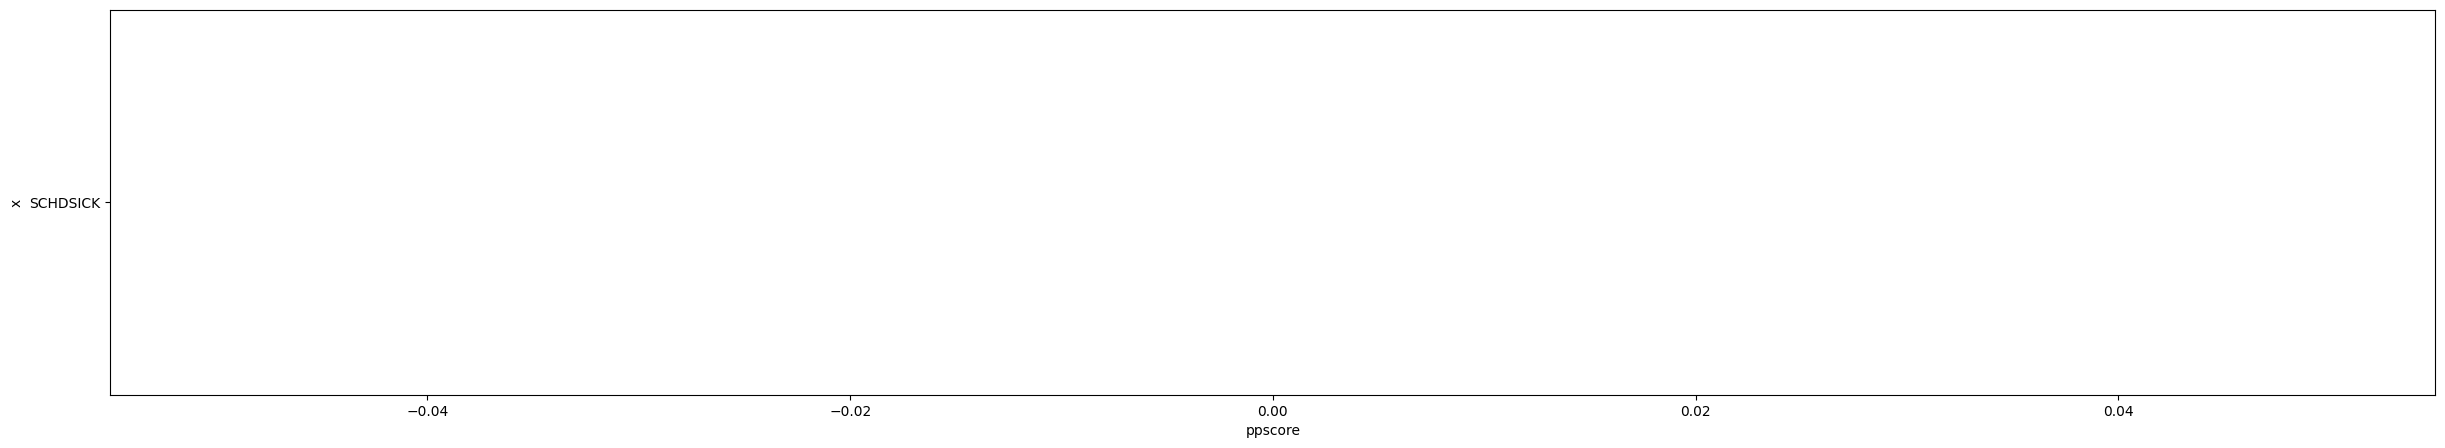

In [172]:
plt.figure(figsize=(30, 5))
sns.barplot(x="ppscore", y="x", data=pps_num_df.sort_values("ppscore", ascending=False))

<Axes: xlabel='ppscore', ylabel='x'>

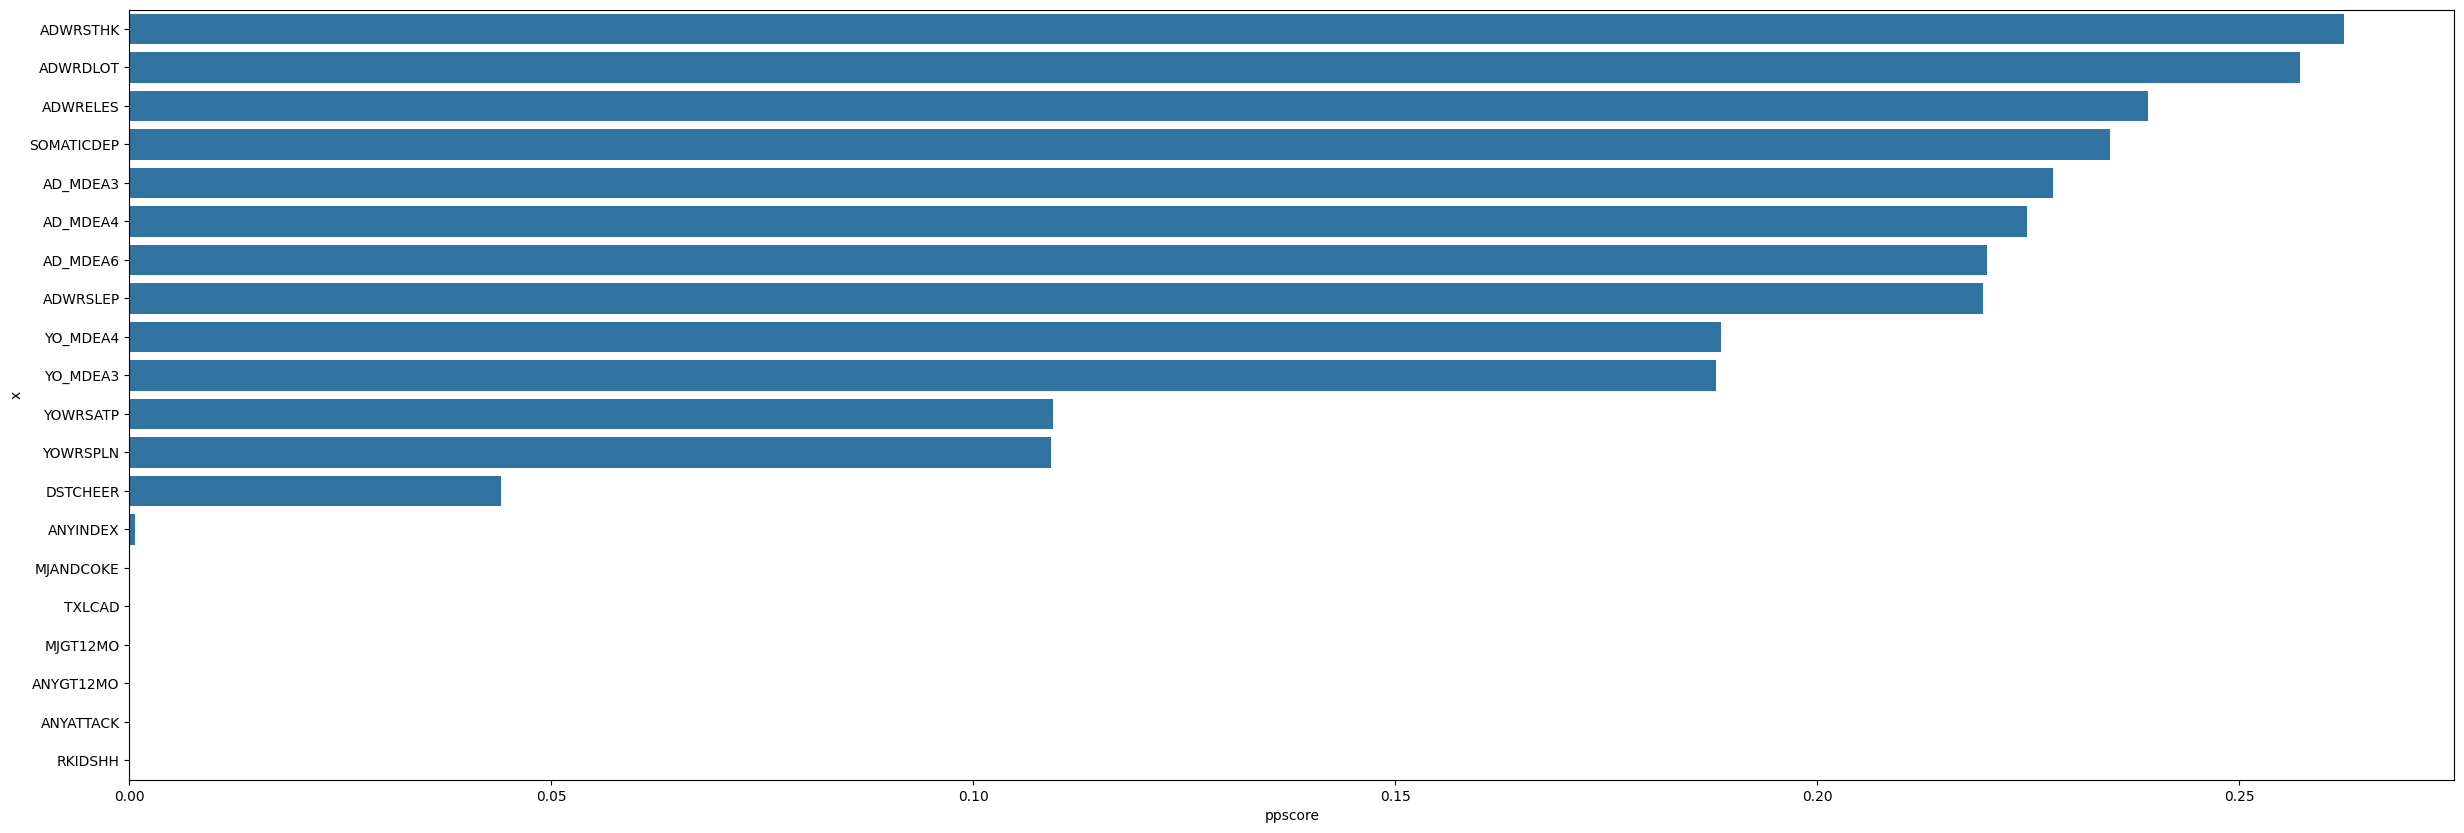

In [174]:
plt.figure(figsize=(30, 10)) # Why are these values so low??
sns.barplot(x="ppscore", y="x", data=pps_cat_df.head(20))

### Analysis Performed For Different Groups

In [19]:
def split_by_col(df, col):
    categories = df[col].unique()
    categories.sort()
    dfs = {}
    for category in categories:
        dfs[f"{category}"] = df[df[col] == category].reset_index(drop=True)
    return dfs


def split_by_cols(df, cols):
    dfs = {}
    for col in cols:
        dfs[col] = split_by_col(df, col)
    return dfs

In [20]:
depression_dfs = split_by_cols(depression_df, ["IRSEX", age_col])